In [1]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
DATA_DIR = Path('/src/fashion')
IMAGE_DIR = Path('/mnt/nas/iMaterial')
ROOT_DIR = Path('/src')

# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 46
IMAGE_SIZE = 512

In [3]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [4]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [5]:
trained_model_path = os.path.join(ROOT_DIR, "bestModel/imbalance_all_noaug_100.h5")

In [6]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 # a memory error occurs when IMAGES_PER_GPU is too high
    
#     BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [7]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert trained_model_path != '', "Provide path to trained weights"
print("Loading weights from ", trained_model_path)
model.load_weights(trained_model_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  /src/bestModel/imbalance_all_noaug_100.h5


In [8]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [9]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [32]:
def predict(image_path,isVisualize=True):
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print("image shape = {}".format(img.shape))

    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    class_labels = ['bg']+label_names
    class_ids = r['class_ids']
    scores = r['scores']

    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)

        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
    
    if isVisualize:
        visualize.display_instances(img, rois, masks, r['class_ids'], 
                                class_labels, r['scores'],
                                title=image_path, figsize=(12, 12))
    
    return class_labels, class_ids, scores, masks, rois

In [38]:
image_path = str(IMAGE_DIR/'test'/'00a325fd4dc22079095ab46330abf7be.jpg')
class_labels, class_ids, scores, masks, rois = predict(image_path,False)
print("class_labels - {}".format(class_labels))
print("class_labels shape - {}".format(len(class_labels)))
print("class_ids - {}".format(class_ids))
print("class_ids shape- {}".format(class_ids.shape))
print("scores - {}".format(scores))
print("scores shape - {}".format(scores.shape))
print("masks - {}".format(masks.shape))
print("rois - {}".format(rois.shape))


image shape = (4256, 2832, 3)
class_labels - ['bg', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']
class_labels shape - 47
class_ids - [ 7 24  2 24 33 33 32 34]
class_ids shape- (8,)
scores - [0.9942214  0.9941949  0.98972523 0.97618854 0.969583   0.9402753
 0.87217635 0.78650546]
scores shape - (8,)
masks - (4256, 2832, 8)
rois - (8, 4)


In [45]:
masks[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [44]:
map_class = list(map(lambda x: class_labels[x], class_ids))
print("map_class - {}".format(map_class))
print("map_class len- {}".format(len(map_class)))

map_class - ['pants', 'shoe', 'top, t-shirt, sweatshirt', 'shoe', 'pocket', 'pocket', 'sleeve', 'neckline']
map_class len- 8


In [ ]:
TEST_DIR=str(IMAGE_DIR/'test')

In [ ]:
os.chdir(TEST_DIR)
print(TEST_DIR)
test_images = glob.glob("*.jpg")
sample_images = random.sample(test_images,k=2)
for file in sample_images:
    image_path = str(IMAGE_DIR/'test'/file)
    print(file)
    predict(image_path)

In [ ]:
!pip install snakeviz

In [ ]:
%load_ext snakeviz

In [ ]:
%%snakeviz
for file in sample_images:
    image_path = str(IMAGE_DIR/'test'/file)
    print(file)
    predict(image_path)

image shape = (210, 89, 3)


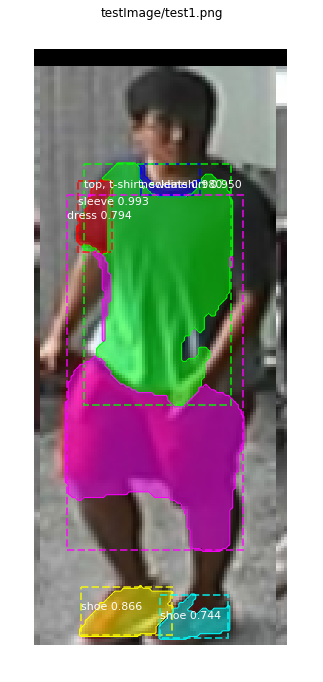

(['bg',
  'shirt, blouse',
  'top, t-shirt, sweatshirt',
  'sweater',
  'cardigan',
  'jacket',
  'vest',
  'pants',
  'shorts',
  'skirt',
  'coat',
  'dress',
  'jumpsuit',
  'cape',
  'glasses',
  'hat',
  'headband, head covering, hair accessory',
  'tie',
  'glove',
  'watch',
  'belt',
  'leg warmer',
  'tights, stockings',
  'sock',
  'shoe',
  'bag, wallet',
  'scarf',
  'umbrella',
  'hood',
  'collar',
  'lapel',
  'epaulette',
  'sleeve',
  'pocket',
  'neckline',
  'buckle',
  'zipper',
  'applique',
  'bead',
  'bow',
  'flower',
  'fringe',
  'ribbon',
  'rivet',
  'ruffle',
  'sequin',
  'tassel'],
 array([32, 34,  2, 24, 11, 24], dtype=int32),
 array([0.9929939 , 0.979908  , 0.950468  , 0.86577463, 0.79394305,
        0.7444463 ], dtype=float32),
 array([[[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         ...,
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0],
       

In [46]:
testImage = 'testImage/test1.png'
predict(testImage)